In [1]:
import torch, PIL

In [2]:
model, img_transform, tokenizer, post_processor, plot_results = torch.hub.load(".", 'flickr_base_model', source="local")

/opt/homebrew/Caskroom/miniconda/base/envs/GPML/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/Caskroom/miniconda/base/envs/GPML/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/GPML/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of the mode

In [3]:
device = "cpu"
img = PIL.Image.open("sample.jpg")
caption = "three<mask>in a room"
# img = PIL.Image.open("t.jpg")
# caption = "a man sitting on a <mask> riding a <mask> on the <mask>"
model = model.to(device)
imgs_tensor = img_transform(img).to(device).unsqueeze(0)
tokens_tensor = tokenizer(caption, return_tensors="pt").to(device)
outputs = model(imgs_tensor, tokens_tensor, one_pass=True)

In [4]:
processed_outputs = post_processor(outputs, img, tokenizer)

In [5]:
processed_outputs.keys()

dict_keys(['cap', 'bboxes'])

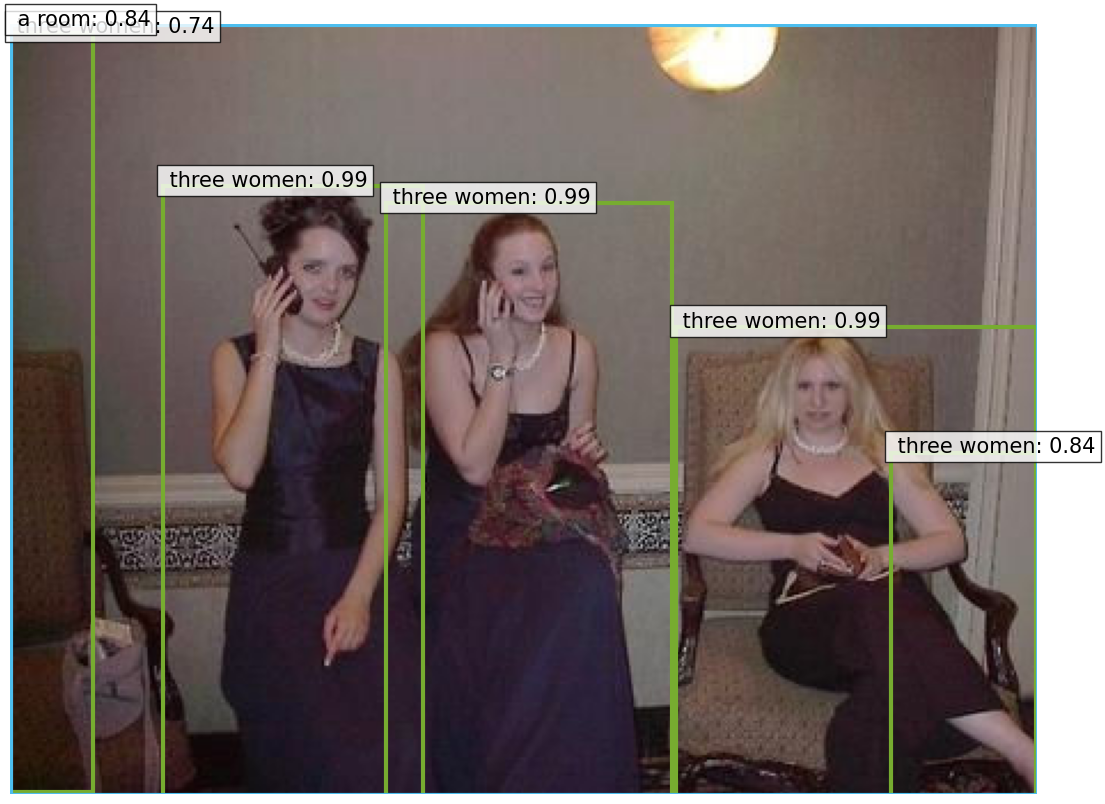

 hardthree women in a room.


In [6]:
plot_results(img, processed_outputs)
print(processed_outputs['cap'])